## PLEASE READ: DATA DOWNLOAD

**Before** running this notebook please check that:

Datasets below are in the data/curated folder:

    1. education.csv
    2. primary_school_locations.csv
    3. secondary_school_locations.csv

All shapefiles from the GOOGLE DRIVE folder in this link have been downloaded and moved into the `data/map` folder:
https://drive.google.com/drive/folders/1ieSGukJv0m51em_y1o0NGSRZ6jb-5h9u?usp=sharing

----

#### Imports

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import folium
from folium.plugins import HeatMap
import seaborn as sns
import contextily as ctx
from folium import Choropleth, GeoJson, GeoJsonTooltip
from folium import IFrame
from branca.element import Template, MacroElement

#Creation of directory for plots 
plot_directory = '../../plots/education_visualisations'

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

In [12]:
# reading required dfs
final_suburb_counts = gpd.read_file("../../data/curated/education.csv")
primary_schools_df_final = gpd.read_file("../../data/raw/primary_school_locations.csv")
final_secondary_schools_df = gpd.read_file("../../data/raw/secondary_school_locations.csv")

# load shapefile
vic_suburbs = gpd.read_file("../../data/map/VIC Localities Shape File/gda2020_vicgrid/esrishape/whole_of_dataset/victoria/VMADMIN/LOCALITY_POLYGON.shp")

In [13]:
# convert all columns except 'suburb' and 'geometry' to float for all dfs
columns_to_convert = [col for col in final_suburb_counts.columns if col not in ['suburb']]
for col in columns_to_convert:
    final_suburb_counts[col] = pd.to_numeric(final_suburb_counts[col], errors='coerce').astype(float)

columns_to_convert = [col for col in primary_schools_df_final.columns if col not in ['suburb','school_name', 'school_type']]
for col in columns_to_convert:
    primary_schools_df_final[col] = pd.to_numeric(primary_schools_df_final[col], errors='coerce').astype(float)

columns_to_convert = [col for col in final_secondary_schools_df.columns if col not in ['suburb','school_name', 'school_type']]
for col in columns_to_convert:
    final_secondary_schools_df[col] = pd.to_numeric(final_secondary_schools_df[col], errors='coerce').astype(float)

In [14]:
# rename 'GAZLOC' to gazetted locality and filter the dataframe
vic_suburbs_filtered = vic_suburbs[['GAZLOC', 'geometry']].rename(columns={'GAZLOC': 'suburb'})
vic_suburbs_filtered['suburb'] = vic_suburbs_filtered['suburb'].str.lower()

# merge geographical data with education counts
vic_education_gdf = vic_suburbs_filtered.merge(final_suburb_counts, on='suburb', how='inner')

# reproject to a projected CRS for accurate area calculation (e.g., VICGRID94)
vic_education_gdf = vic_education_gdf.to_crs(epsg=3111)

# calculate the area in square kilometers
vic_education_gdf['area_km2'] = vic_education_gdf['geometry'].area / 1e6

# calculate education density (counts of institutions per km²)
vic_education_gdf['education_density'] = vic_education_gdf['total_education_count'] / vic_education_gdf['area_km2']

# transform back to a geographic CRS for visualization in Folium
vic_education_gdf = vic_education_gdf.to_crs(epsg=4326)

#### Education Density Heatmap

In [20]:
# create a base map centered on Victoria, Australia
map_victoria = folium.Map(location=[-37.8136, 144.9631], zoom_start=8, tiles="cartodb positron")

# add the choropleth map for education density
choropleth = Choropleth(
    geo_data=vic_education_gdf.__geo_interface__,  
    data=vic_education_gdf,                       
    columns=['suburb', 'education_density'],     
    key_on='feature.properties.suburb',        
    fill_color='YlOrRd',                   
    fill_opacity=0.7,                        
    line_opacity=0.2,                         
    highlight=True,                               
    legend_name='Education Density (institutions per km²)'
).add_to(map_victoria)

# display the map
#map_victoria

# save the combined interactive map as an HTML file
map_victoria.save('../../plots/education_visualisations/education_density_heatmap.html')


#### Heatmap that has both Seondary Schools and Suburb Labels

In [21]:
# calculate centroids
vic_education_gdf['centroid_lat'] = vic_education_gdf['geometry'].centroid.y
vic_education_gdf['centroid_lon'] = vic_education_gdf['geometry'].centroid.x

# create a base map centered on Victoria, Australia
map_victoria = folium.Map(location=[-37.8136, 144.9631], zoom_start=8, tiles="cartodb positron")

# add the choropleth map for education density
choropleth = Choropleth(
    geo_data=vic_education_gdf.__geo_interface__,  
    data=vic_education_gdf,                      
    columns=['suburb', 'education_density'],     
    key_on='feature.properties.suburb',        
    fill_color='YlOrRd',                          
    fill_opacity=0.7,                          
    line_opacity=0.2,                          
    highlight=True,                               
    legend_name='Education Density (institutions per km²)' 
).add_to(map_victoria)

# add tooltips to display suburb and education density on hover
tooltip = GeoJsonTooltip(
    fields=['suburb', 'education_density'],
    aliases=['Suburb:', 'Education Density:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """
)

# apply the tooltip to the GeoJson layer
GeoJson(
    vic_education_gdf.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0
    },
    tooltip=tooltip
).add_to(map_victoria)

# add markers for the top 10 suburbs by education density
top_10_suburbs = vic_education_gdf.nlargest(10, 'education_density')

for _, row in top_10_suburbs.iterrows():
    folium.Marker(
        location=[row['centroid_lat'], row['centroid_lon']],
        popup=f"{row['suburb']}: {row['education_density']:.2f} institutions/km²",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_victoria)

# add markers for the top 10 secondary schools
top_secondary_schools = final_secondary_schools_df.nsmallest(10, 'rank')

# split top 20 into top 10
top_10_secondary_schools = top_secondary_schools.iloc[:10]

# add markers for the top 10 secondary schools (red)
for _, row in top_10_secondary_schools.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['school_name'],
        icon=folium.Icon(color='green', icon='info-sign'),
    ).add_to(map_victoria)

# add a legend for the marker colors
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 250px; height: 100px;
            border:2px solid grey; z-index:9999; font-size:12px;
            background-color:white;">
    &nbsp;<b>Legend</b><br>
    &nbsp;<i class="fa fa-map-marker fa-2x" style="color:green"></i>&nbsp;Top 10 Secondary Schools<br>
    &nbsp;<i class="fa fa-map-marker fa-2x" style="color:blue"></i>&nbsp;Top 10 Suburbs by Education Density<br>
</div>
'''
map_victoria.get_root().html.add_child(folium.Element(legend_html))

# save the combined interactive map as an HTML file
map_victoria.save('../../plots/education_visualisations/education_density_heatmap_with_labels.html')

# display the map
#map_victoria


/tmp/ipykernel_59994/828592727.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vic_education_gdf['centroid_lat'] = vic_education_gdf['geometry'].centroid.y
/tmp/ipykernel_59994/828592727.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vic_education_gdf['centroid_lon'] = vic_education_gdf['geometry'].centroid.x


#### Heatmap showing Canterbury, Armadale and Kew

In [22]:
# calculate centroids
vic_education_gdf['centroid_lat'] = vic_education_gdf['geometry'].centroid.y
vic_education_gdf['centroid_lon'] = vic_education_gdf['geometry'].centroid.x

# create a base map centered on Victoria, Australia
map_victoria = folium.Map(location=[-37.8136, 144.9631], zoom_start=8, tiles="cartodb positron")

# add the choropleth map for education density
choropleth = Choropleth(
    geo_data=vic_education_gdf.__geo_interface__, 
    data=vic_education_gdf,                     
    columns=['suburb', 'education_density'],      
    key_on='feature.properties.suburb',        
    fill_color='YlOrRd',                      
    fill_opacity=0.7,                           
    line_opacity=0.2,                        
    highlight=True,                             
    legend_name='Education Density (institutions per km²)' 
).add_to(map_victoria)

# add tooltips to display suburb and education density on hover
tooltip = GeoJsonTooltip(
    fields=['suburb', 'education_density'],
    aliases=['Suburb:', 'Education Density:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """
)

# apply the tooltip to the GeoJson layer
GeoJson(
    vic_education_gdf.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0
    },
    tooltip=tooltip
).add_to(map_victoria)

# add markers for the suburbs
highlighted_suburbs = ['kew', 'armadale', 'canterbury']
highlighted_suburbs_gdf = vic_education_gdf[vic_education_gdf['suburb'].str.lower().isin(highlighted_suburbs)]

# add markers for the highlighted suburbs
for _, row in highlighted_suburbs_gdf.iterrows():
    folium.Marker(
        location=[row['centroid_lat'], row['centroid_lon']],
        popup=f"{row['suburb'].title()}: {row['education_density']:.2f} institutions/km²",
        icon=folium.Icon(color='blue', icon='info-sign', prefix='fa')  # Adjust icon as needed
    ).add_to(map_victoria)

# save the combined interactive map as an HTML file
map_victoria.save('../../plots/education_visualisations/ppt_education_density_heatmap.html')

# Display the map
#map_victoria

/tmp/ipykernel_59994/908777834.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vic_education_gdf['centroid_lat'] = vic_education_gdf['geometry'].centroid.y
/tmp/ipykernel_59994/908777834.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vic_education_gdf['centroid_lon'] = vic_education_gdf['geometry'].centroid.x


#### Bar chart: Top 20 suburbs based on education density, secondary school rank, primary school density

/tmp/ipykernel_59994/2082129179.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_59994/2082129179.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_59994/2082129179.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


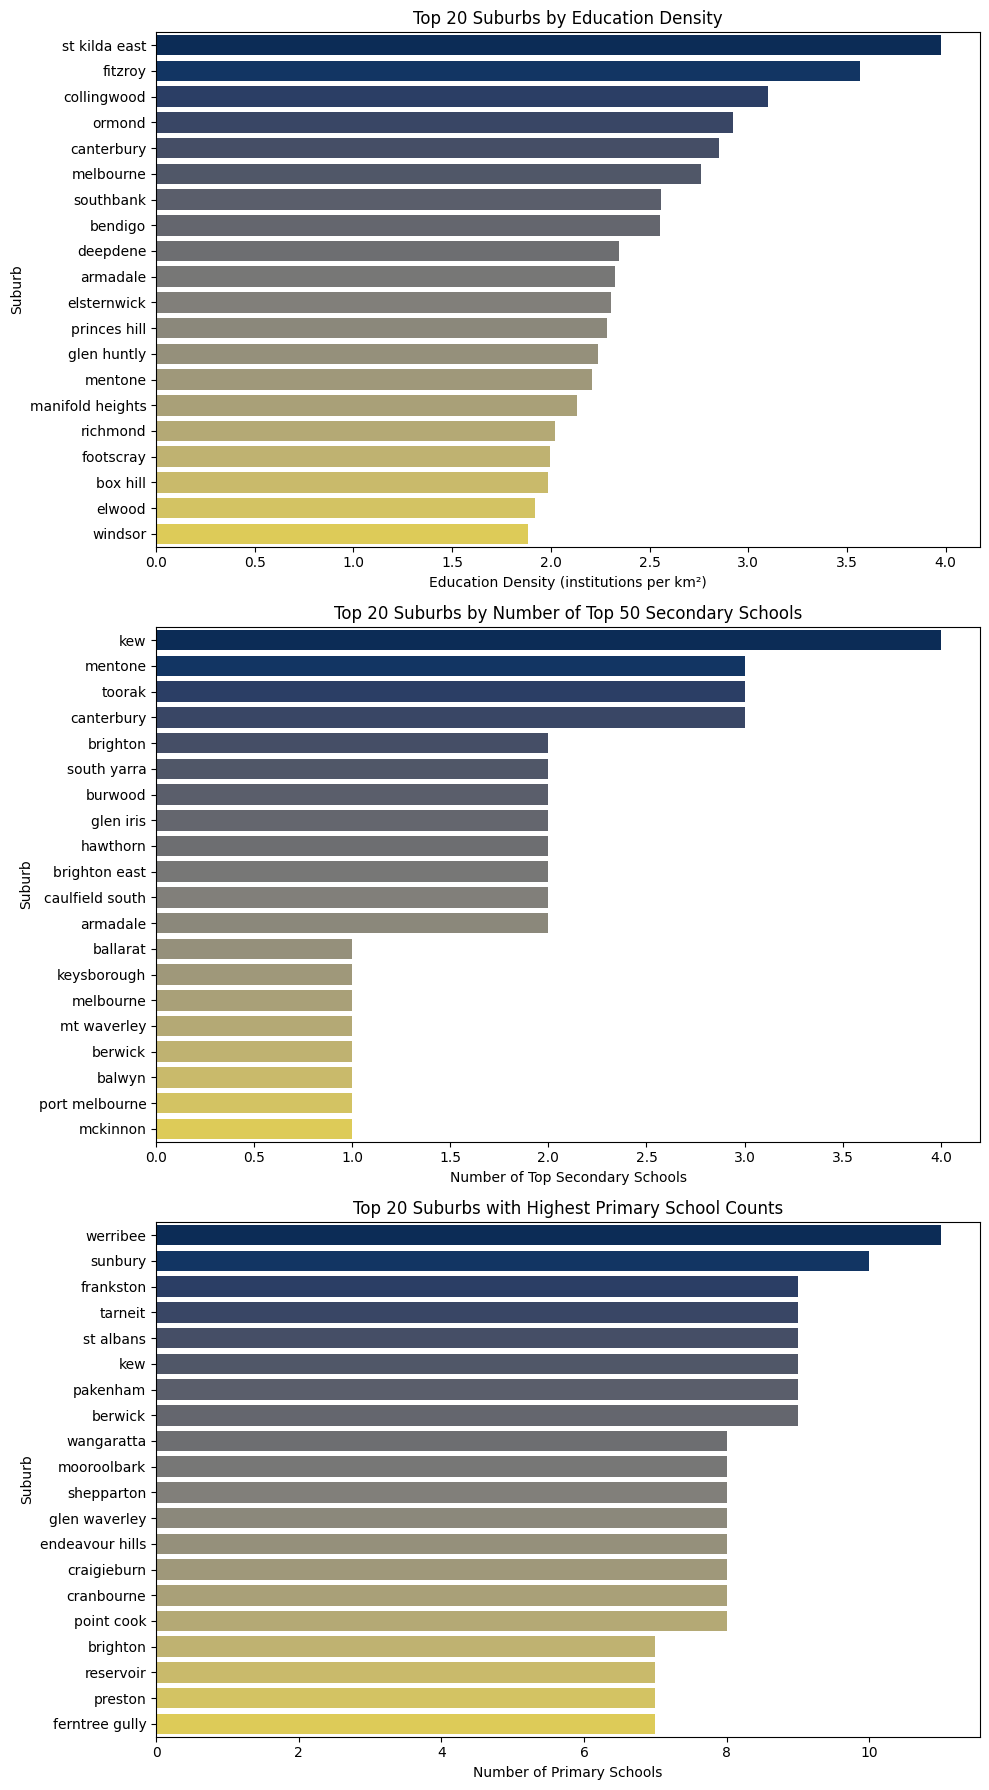

Suburbs appearing in all three plots: set()
Suburbs appearing in at least two plots: {'mentone', 'melbourne', 'armadale', 'kew', 'berwick', 'brighton', 'canterbury'}


In [23]:
# create subplots for the three bar charts
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# top 20 suburbs by education density
top_20_suburbs = vic_education_gdf.nlargest(20, 'education_density')
sns.barplot(
    x='education_density', 
    y='suburb', 
    data=top_20_suburbs, 
    palette='cividis',
    ax=axes[0]
)
axes[0].set_title('Top 20 Suburbs by Education Density')
axes[0].set_xlabel('Education Density (institutions per km²)')
axes[0].set_ylabel('Suburb')

# top 20 suburbs by number of top 50 secondary schools
top_50_secondary_schools = final_secondary_schools_df.nsmallest(50, 'rank')
suburb_counts = top_50_secondary_schools['suburb'].value_counts().reset_index()
suburb_counts.columns = ['suburb', 'top_school_count']
top_20_secondary_school_suburbs = suburb_counts.nlargest(20, 'top_school_count')
sns.barplot(
    x='top_school_count',
    y='suburb',
    data=top_20_secondary_school_suburbs,
    palette='cividis',
    ax=axes[1]
)
axes[1].set_title('Top 20 Suburbs by Number of Top 50 Secondary Schools')
axes[1].set_xlabel('Number of Top Secondary Schools')
axes[1].set_ylabel('Suburb')

# top 20 suburbs by primary school density
vic_education_gdf['primary_school_count'] = pd.to_numeric(vic_education_gdf['primary_school_count'], errors='coerce').fillna(0)
top_20_primary_suburbs = vic_education_gdf.nlargest(20, 'primary_school_count')
sns.barplot(
    x='primary_school_count',
    y='suburb',
    data=top_20_primary_suburbs,
    palette='cividis',
    ax=axes[2]
)
axes[2].set_title('Top 20 Suburbs with Highest Primary School Counts')
axes[2].set_xlabel('Number of Primary Schools')
axes[2].set_ylabel('Suburb')

# adjust layout to avoid overlap
plt.tight_layout()

# save the combined plots as a single PNG file
plt.savefig('../../plots/education_visualisations/combined_education_suburb_plots.png', dpi=300, bbox_inches='tight')

# Display the plots
plt.show()

# identify overlaps between the three lists
set_education_density = set(top_20_suburbs['suburb'])
set_secondary_schools = set(top_20_secondary_school_suburbs['suburb'])
set_primary_school_counts = set(top_20_primary_suburbs['suburb'])

# suburbs appearing in all three plots
all_three = set_education_density & set_secondary_schools & set_primary_school_counts

# suburbs appearing in any two plots
in_two = (set_education_density & set_secondary_schools) | \
         (set_secondary_schools & set_primary_school_counts) | \
         (set_primary_school_counts & set_education_density)

print("Suburbs appearing in all three plots:", all_three)
print("Suburbs appearing in at least two plots:", in_two)

#### Bar chart: Top 10 suburbs based on education density, average secondary school rankings, primary school density

Suburbs appearing in at least two plots: set()


/tmp/ipykernel_59994/158293336.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_59994/158293336.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_59994/158293336.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


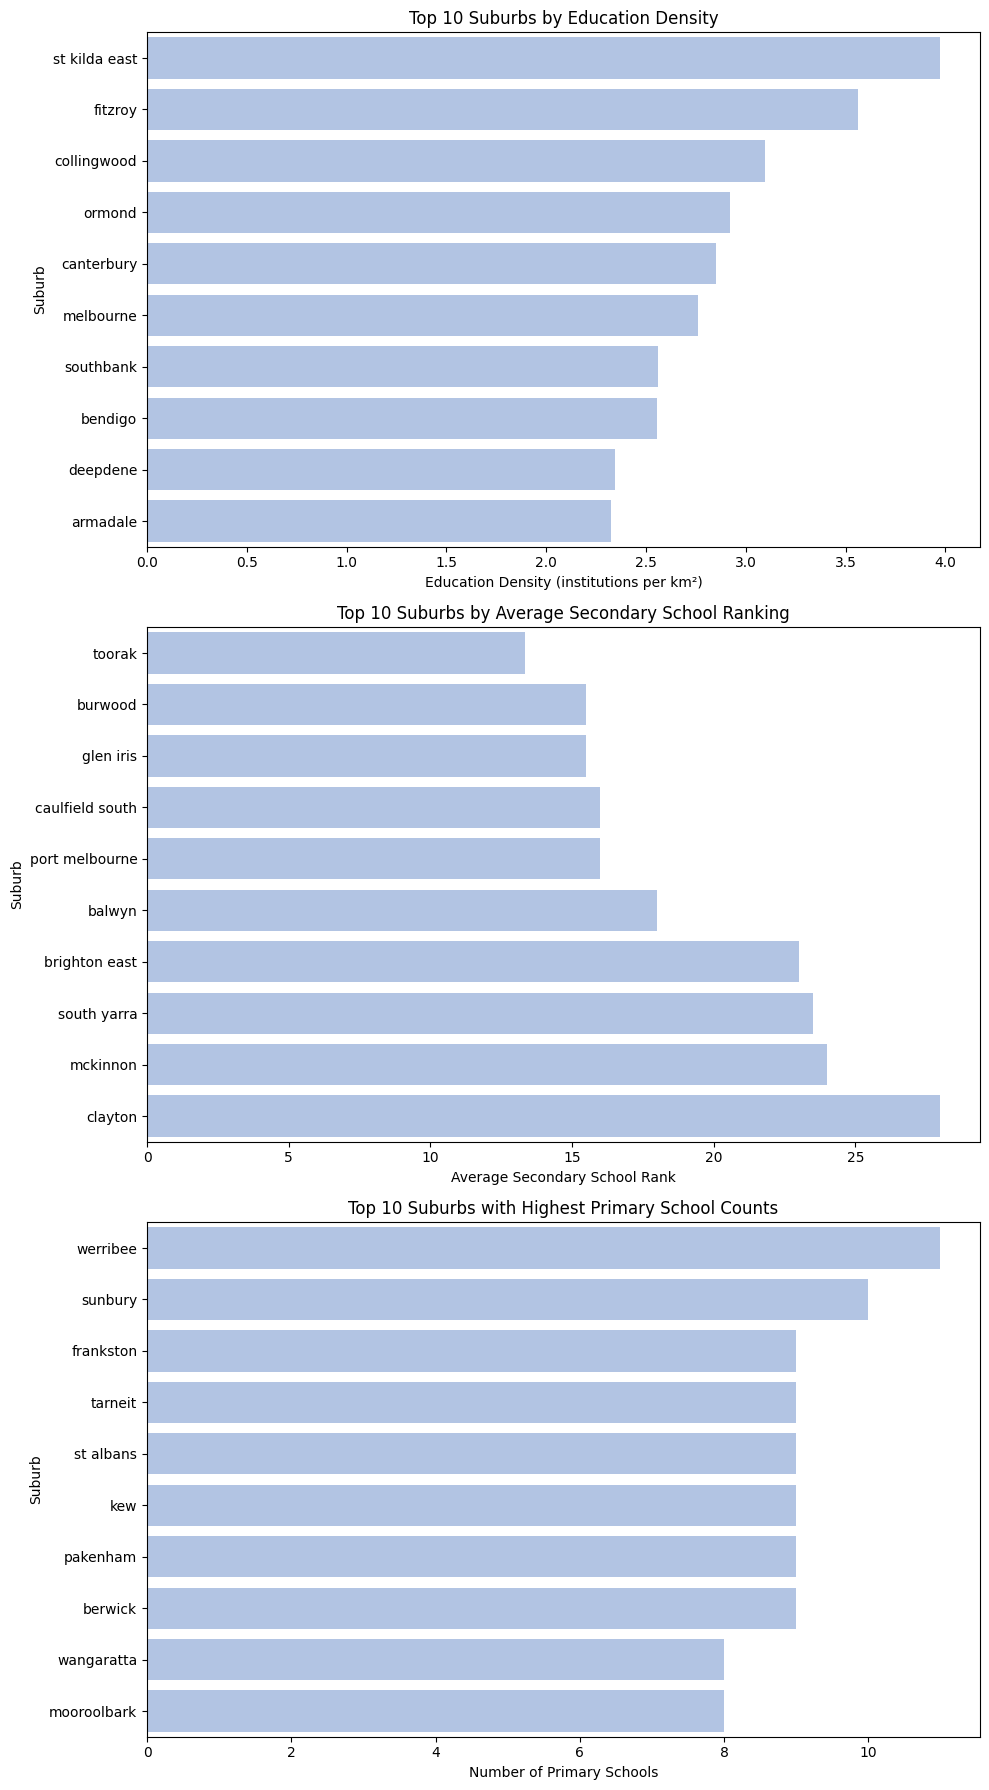

In [24]:
# define colors
highlight_color = '#FFF9AF'  # yellow highlight for suburbs appearing in two or more plots
default_color = '#AAC2EB'    # blue for all other bars

# function to assign colors based on condition
def assign_colors(suburbs_list, in_two):
    return [highlight_color if suburb in in_two else default_color for suburb in suburbs_list]

# identify overlaps between the three lists
set_education_density = set(vic_education_gdf.nlargest(10, 'education_density')['suburb'])
set_secondary_schools = set(vic_education_gdf.nsmallest(10, 'avg_secondary_school_rank')['suburb'])
set_primary_school_counts = set(vic_education_gdf.nlargest(10, 'primary_school_count')['suburb'])

# suburbs appearing in any two plots
in_two = (set_education_density & set_secondary_schools) | \
         (set_secondary_schools & set_primary_school_counts) | \
         (set_primary_school_counts & set_education_density)

print("Suburbs appearing in at least two plots:", in_two)

# create subplots for the three bar charts
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# top 10 suburbs by education density
top_10_suburbs = vic_education_gdf.nlargest(10, 'education_density')
colors_1 = assign_colors(top_10_suburbs['suburb'], in_two)

sns.barplot(
    x='education_density', 
    y='suburb', 
    data=top_10_suburbs, 
    palette=colors_1,
    ax=axes[0]
)
axes[0].set_title('Top 10 Suburbs by Education Density')
axes[0].set_xlabel('Education Density (institutions per km²)')
axes[0].set_ylabel('Suburb')

# top 10 suburbs by average secondary school ranking (excluding 0 values)
# filter out 0 values in 'avg_secondary_school_rank'
filtered_secondary_rank_suburbs = vic_education_gdf[vic_education_gdf['avg_secondary_school_rank'] > 0]

# find top 10 suburbs based on avg_secondary_school_rank
top_10_secondary_rank_suburbs = filtered_secondary_rank_suburbs.nsmallest(10, 'avg_secondary_school_rank')
colors_2 = assign_colors(top_10_secondary_rank_suburbs['suburb'], in_two)

sns.barplot(
    x='avg_secondary_school_rank',
    y='suburb',
    data=top_10_secondary_rank_suburbs,
    palette=colors_2,
    ax=axes[1]
)
axes[1].set_title('Top 10 Suburbs by Average Secondary School Ranking')
axes[1].set_xlabel('Average Secondary School Rank')
axes[1].set_ylabel('Suburb')

# top 10 suburbs by primary school counts
top_10_primary_suburbs = vic_education_gdf.nlargest(10, 'primary_school_count')
colors_3 = assign_colors(top_10_primary_suburbs['suburb'], in_two)

sns.barplot(
    x='primary_school_count',
    y='suburb',
    data=top_10_primary_suburbs,
    palette=colors_3,
    ax=axes[2]
)
axes[2].set_title('Top 10 Suburbs with Highest Primary School Counts')
axes[2].set_xlabel('Number of Primary Schools')
axes[2].set_ylabel('Suburb')

# adjust layout to avoid overlap
plt.tight_layout()

# display the plots
plt.show()

#### Bar chart: Top 10 suburbs based on education density, number of top 50 secondary schools, primary school density

Suburbs appearing in at least two plots: {'melbourne', 'collingwood', 'fitzroy', 'southbank', 'ormond', 'bendigo', 'armadale', 'st kilda east', 'deepdene', 'canterbury'}


/tmp/ipykernel_59994/4149111380.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_59994/4149111380.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_59994/4149111380.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


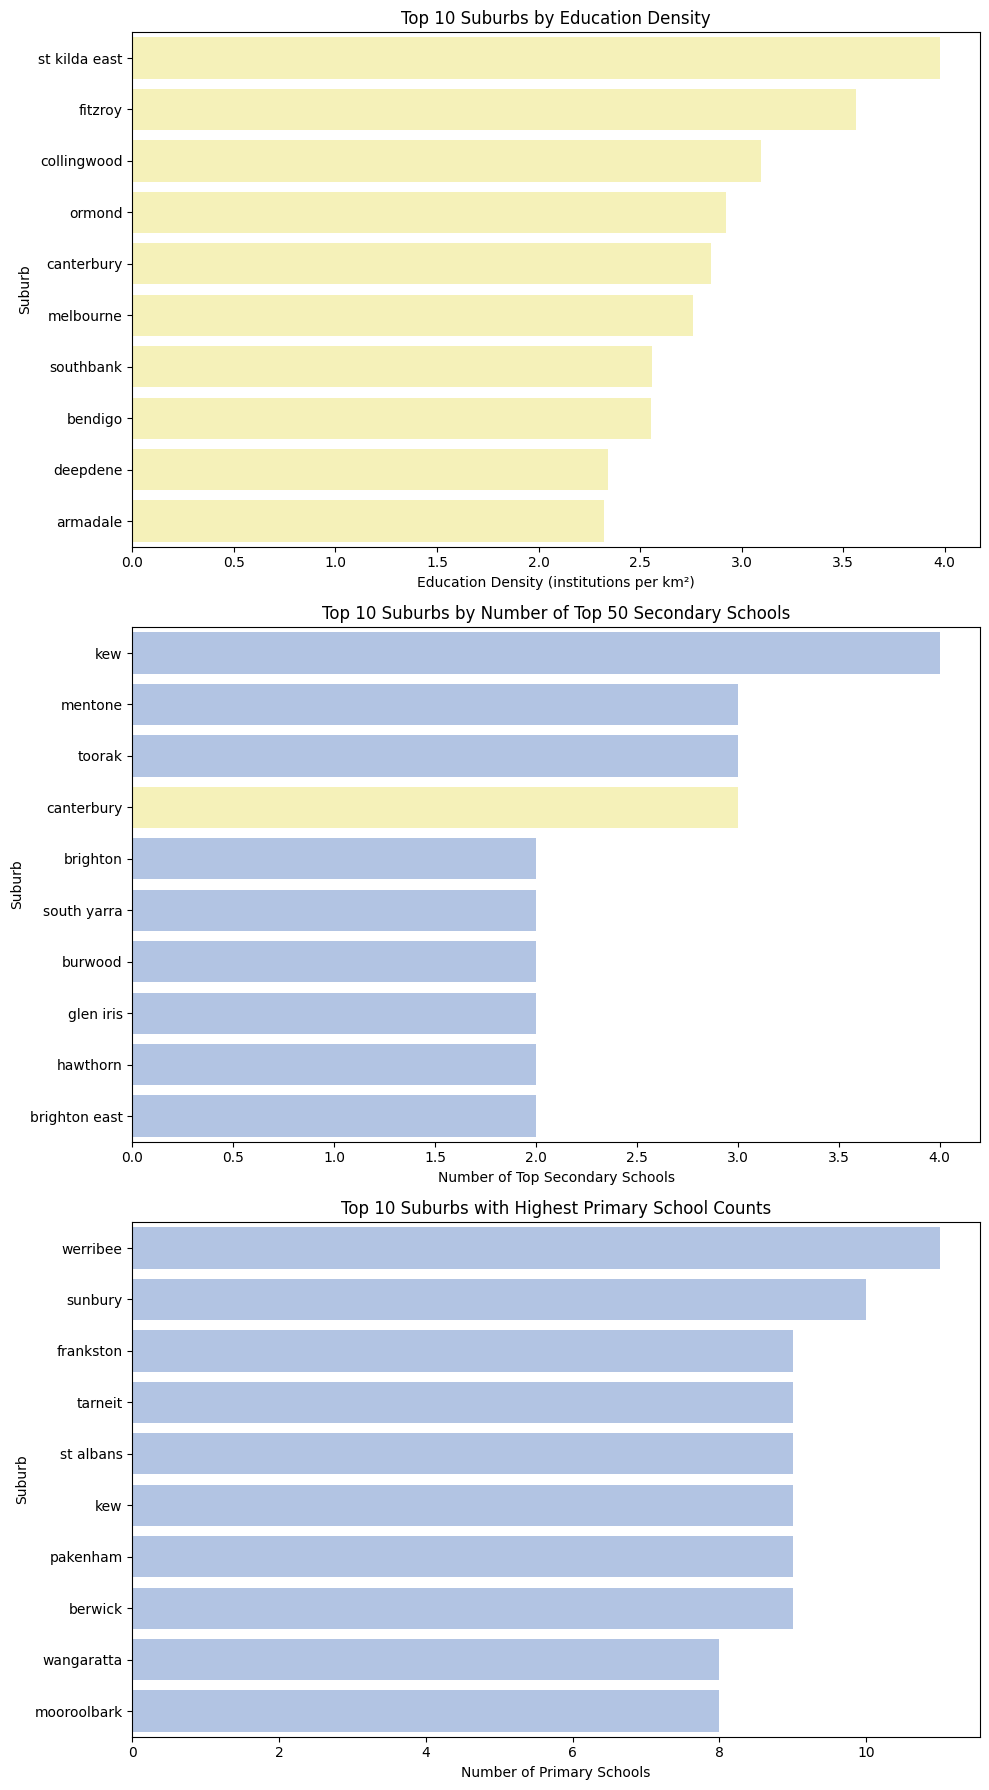

In [25]:
# identify overlaps between the three lists
set_education_density = set(vic_education_gdf.nlargest(10, 'education_density')['suburb'])
set_secondary_schools = set(top_10_suburbs['suburb'])  # Updated to use the new top 10 from the top 50 secondary schools count
set_primary_school_counts = set(vic_education_gdf.nlargest(10, 'primary_school_count')['suburb'])

# suburbs appearing in any two plots
in_two = (set_education_density & set_secondary_schools) | \
         (set_secondary_schools & set_primary_school_counts) | \
         (set_primary_school_counts & set_education_density)

print("Suburbs appearing in at least two plots:", in_two)

# create subplots for the three bar charts
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# top 10 suburbs by education density
top_10_suburbs_density = vic_education_gdf.nlargest(10, 'education_density')
colors_1 = assign_colors(top_10_suburbs_density['suburb'], in_two)

sns.barplot(
    x='education_density', 
    y='suburb', 
    data=top_10_suburbs_density, 
    palette=colors_1,
    ax=axes[0]
)
axes[0].set_title('Top 10 Suburbs by Education Density')
axes[0].set_xlabel('Education Density (institutions per km²)')
axes[0].set_ylabel('Suburb')

# top 10 Suburbs by number of top 50 secondary schools
# filter top 50 secondary schools by rank
top_50_secondary_schools = final_secondary_schools_df.nsmallest(50, 'rank')

# group by suburb and count the number of top schools in each suburb
suburb_counts = top_50_secondary_schools['suburb'].value_counts().reset_index()
suburb_counts.columns = ['suburb', 'top_school_count']

# sort and select the top 10 suburbs
top_10_suburbs_secondary = suburb_counts.nlargest(10, 'top_school_count')
colors_2 = assign_colors(top_10_suburbs_secondary['suburb'], in_two)

# create bar plot
sns.barplot(
    x='top_school_count',
    y='suburb',
    data=top_10_suburbs_secondary,
    palette=colors_2,
    ax=axes[1]
)
axes[1].set_title('Top 10 Suburbs by Number of Top 50 Secondary Schools')
axes[1].set_xlabel('Number of Top Secondary Schools')
axes[1].set_ylabel('Suburb')

# top 10 suburbs by primary school counts
top_10_primary_suburbs = vic_education_gdf.nlargest(10, 'primary_school_count')
colors_3 = assign_colors(top_10_primary_suburbs['suburb'], in_two)

sns.barplot(
    x='primary_school_count',
    y='suburb',
    data=top_10_primary_suburbs,
    palette=colors_3,
    ax=axes[2]
)
axes[2].set_title('Top 10 Suburbs with Highest Primary School Counts')
axes[2].set_xlabel('Number of Primary Schools')
axes[2].set_ylabel('Suburb')

# adjust layout to avoid overlap
plt.tight_layout()

# save the combined plots as a single PNG file
plt.savefig('../../plots/education_visualisations/ppt_education_suburb_plots.png', dpi=300, bbox_inches='tight')

# display the plots
plt.show()